# Space Mission Case Study

This case study demonstrates using Pacti for the verification of an autonomous space mission system that uses an onboard planning/scheduling system based on a generalized timeline representation as described in [Chien et al. 2012](#ref1). Examples of such timeline representation modeling include [Rabideau et al. 2017](#ref2) and [Chen et al. 2003](#ref3). Such systems reflect deliberate design decisions to limit the expressiveness of constraint formulas for planning/scheduling due to considerations of the limited computational resources available on space mission systems and performance requirements for computing solutions. In contrast to the general class of 1st order constraint formulas of PDDL (see [Ghallab et al. 1998](#ref4)), such systems involve computationally efficient linear inequalities of the form:

$$aX <= b$$

where $$x$$ is a timeline variable and $$a,b$$ are constants that may encode temporal information about the schedule of a task instance.

Since this class of constraint formula fits the expressiveness of Pacti's polyhedral constraints, this case study explores modeling tasks for an onboard automated planning/scheduling system as assume-guarantee components using Pacti.

In [1]:
%matplotlib widget

from IPython import display
from base64 import b64decode
from pacti.terms.polyhedra import *
from pacti.iocontract import IoContract, Var
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import patches
import pdb
from matplotlib.collections import PatchCollection
from contract_utils import *

varPrefixes=["t", "soc", "d", "e", "r", "temp"]
epsilon = 1e-3

## A simple space mission scenario

The following figure illustrates a simplified space mission scenario for a cubesat-sized spacecraft to approach a small body asteroid described in more detail in [Nesnas et al. 2021](ref5). Note: the Sun, Earth, spacecraft and small body asteroid are shown at different scales for illustration purposes.

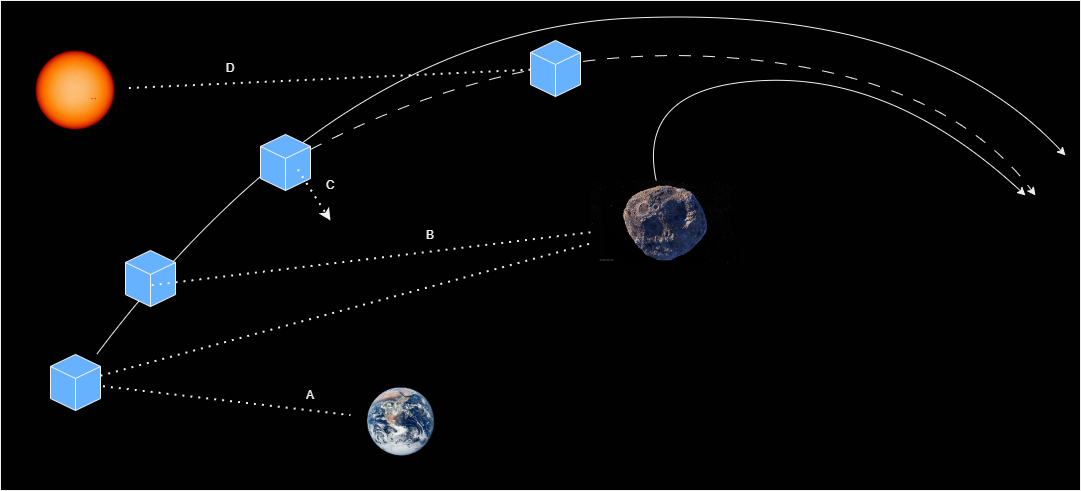

In [2]:
display.Image(b64decode(figure_space_mission_scenario))


To communicate with Earth, the cubesat-sized spacecraft (blue cube) must orient its fixed antennas towards Earth (line A). Depending on the trajectory, this orientation may be suboptimal for the spacecraft panels to produce maximum electrical power (line B). The spacecraft must make optical measurements of the small body asteroid to estimate its relative trajectory (line C) as part of the onboard autonomous navigation. This navigation requires pointing the spacecraft's thrusters in the direction of a velocity vector (line D) according to a trajectory correction maneuver (TCM). After several carefully designed TCMs, the spacecraft will eventually reach the small body asteroid and land on it as described in [Nesnas et al. 2021](ref5). For onboard planning/scheduling these behaviors would be modeled as tasks in the style of [Rabideau et al. 2017](#ref2) and [Chen et al. 2003](#ref3); that is, tasks would involve linear inequality constraints for specifying their pre/post conditions and their effects. The following describes the specification of these behaviors in Pacti's assume-guarantee paradigm.

### Modeling task behaviors as assume-guarantee contracts

The simplified space mission scenario described above involves the following tasks:

| Task Name | Task Description | Pointing Constraint |
| --------- | ---------------- | ------------------- |
| DSN       | Communicate with Earth | Line A |
| PWR       | Ensure power | Line B |
| SBO       | Acquire Small body observations | Line C |
| TCM       | Perform a Trajectory Correction Maneuver | Line D |

The Pacti specifications for these tasks involve the following variables:

| Variable name | Value range | Variable description |
| ------------- | ----------- | -------------------- |
| `t` | $[0-..]$ | time |
| `soc` | $[0-100]$ | Spacecraft's battery state-of-charge |
| `d` | $[0-100]$ | Spacecraft's onboard science data from small body observations |
| `e` | $[0-100]$ | Spacecraft's estimation of its small-body relative trajectory error |
| `r` | $[0-100]$ | Spacecraft's relative distance (100=trajectory at beginning of scenario, 0=trajectory at rendez-vous with small body) |
| `temp` | $[0-100]$ | Spacecraft's thurster temperature (0=cold, 100=hot) |

These variables appear as inputs and outputs of Pacti component specifications as illustrated below for two components, `A` and `B` where the temporal ordering of the schedule of `B` starting after the end of the schedule of `A` corresponds to the composition of `A` and `B` in Pacti.

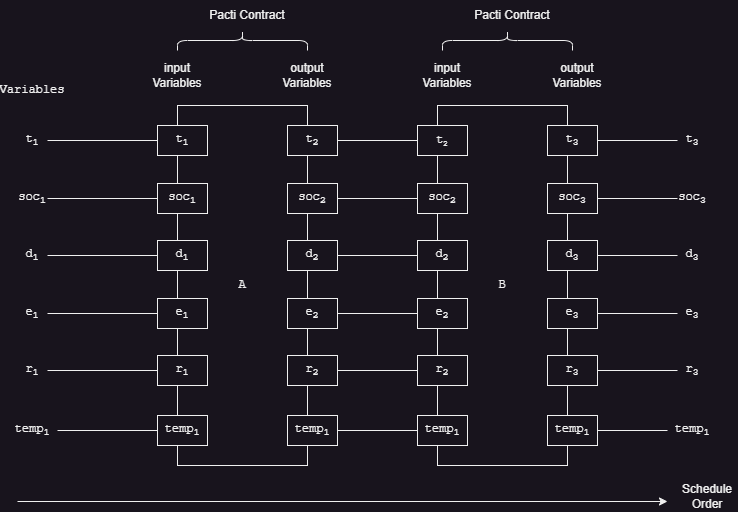

In [3]:
display.Image(b64decode(figure_task_schedule_contracts))

#### Initial scenario conditions

In [4]:
def initial_contract(epsilon: float) -> PolyhedralContract:
  e=1
  spec = PolyhedralContract.from_string(
    InputVars = [],
    OutputVars= [
      #f"t{e}",    # Scheduled end time
      f"soc{e}",  # final battery SOC
      f"d{e}",    # final data volume
      f"e{e}",    # final trajectory error
      f"r{e}",    # final relative distance
      f"temp{e}", # final spacecraft thruster temperature
    ],
    assumptions=[],
    guarantees=[
      #f"t{e} = 0",
      f"-soc{e} <= -100",
      f"-d{e} <= 0",
      f"-e{e} <= 0",
      f"-r{e} <= -100",
      f"temp{e} <= {epsilon}",
    ]
  )
  return spec

def nochangeContract(s: int, name: str) -> PolyhedralContract:
  e=s+1
  return PolyhedralContract.from_string(
    InputVars=[ f"{name}{s}" ],
    OutputVars=[ f"{name}{e}" ],
    assumptions=[],
    guarantees=[ f"| {name}{e} - {name}{s} | = 0" ])

def durationContract(s: int, duration: str, epsilon: float) -> PolyhedralContract:
  e=s+1
  return PolyhedralContract.from_string(
    InputVars=[ 
      f"t{s}"   # Scheduled start time
    ],
    OutputVars=[
      f"t{e}"   # Scheduled end time
    ],
    assumptions=[
      # positive scheduled duration
      f"-{duration}{s} <= 0",
    ],
    guarantees=[ 
      # task ends after the duration has elapsed
      f"| t{e} - t{s} - {duration}{s} | <= {epsilon}",])


#### DSN Task (Communicate with Earth)

This function has two significant impacts that are linear with the duration of the task:
- power: the battery discharges proportionally to a consumption rate
- data: the downlinked data volume increases proportionally to a downlink speed

Contract dsn1_power:
InVars: [soc10, dsn10]
OutVars:[soc11]
A: [
  -dsn10 <= 0.0
  4.2 dsn10 - soc10 <= 0.0
]
G: [
  -4.2 dsn10 + soc10 - soc11 <= 0.0
  3.8 dsn10 - soc10 + soc11 <= 0.0
]


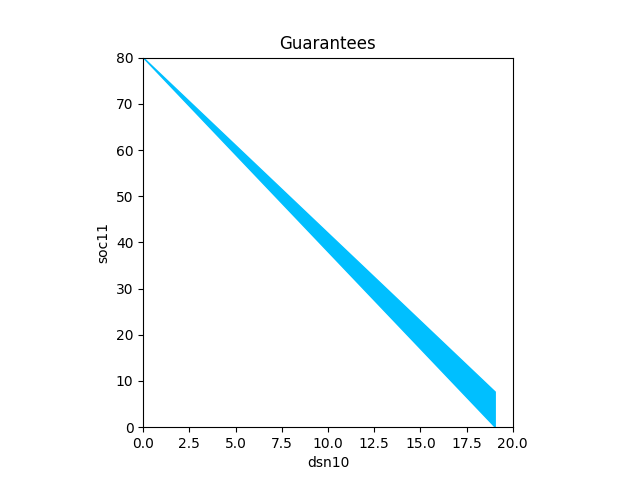

In [5]:
# DSN power viewpoint
# Parameters:
# - s: start index of the timeline variables
# - consumption: (min, max) rate of battery discharge during the task instance
# - epsilon: approximately zero
def DSNpower(s: int, consumption: tuple[float, float], epsilon: float) -> PolyhedralContract:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"soc{s}",  # initial battery SOC
      f"dsn{s}",  # knob variable for DSN duration
    ],
    OutputVars = [
      f"soc{e}",  # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-dsn{s} <= 0",

      # Battery has enough energy for worst-case consumption throughout the task instance
      f"-soc{s} + {consumption[1]}*dsn{s} <= 0",
    ],
    guarantees = [
      # duration*consumption(min) <= soc{s} - soc{e} <= duration*consumption(max)
      f" soc{s} - soc{e} - {consumption[1]}*dsn{s} <= 0",
      f"-soc{s} + soc{e} + {consumption[0]}*dsn{s} <= 0",

      # Battery should not completely discharge
      f"-soc{e} <= 0",
    ])
  return spec

dsn1_power = DSNpower(s=10, consumption=(3.8, 4.2), epsilon=epsilon)
print("Contract dsn1_power:")
print(dsn1_power)

_ = plot_guarantees(contract=dsn1_power,
                x_var=Var("dsn10"),
                y_var=Var("soc11"),
                var_values={
                  Var("soc10"):80,
                },
                x_lims=(0,20),
                y_lims=(0,80))

Contract dsn1_data:
InVars: [d10, dsn10]
OutVars:[d11]
A: [
  -dsn10 <= 0.0
  -d10 <= -1.0
]
G: [
  d10 - d11 - 5.5 dsn10 <= 0.0
  -d10 + d11 + 5.2 dsn10 <= 0.0
  -d11 <= 0.0
]


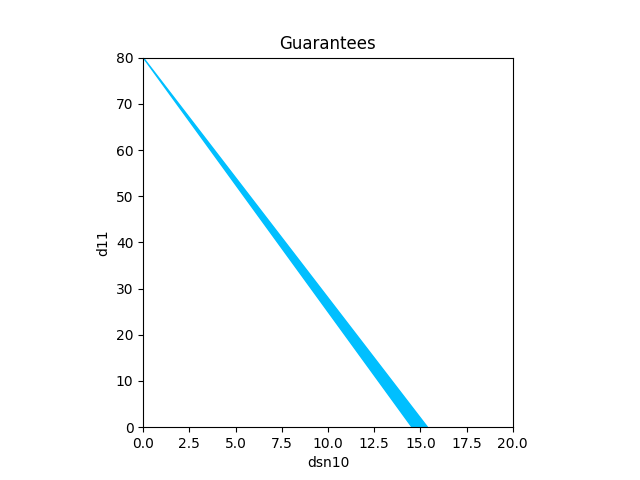

In [6]:
# DSN data viewpoint
# - s: start index of the timeline variables
# - speed: (min, max) downlink rate during the task instance
# - epsilon: approximately zero
def DSNdata(s: int, speed: tuple[float, float], epsilon: float) -> PolyhedralContract:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"d{s}",    # initial data volume
      f"dsn{s}",  # knob variable for DSN duration
    ],
    OutputVars = [
      f"d{e}",    # final data volume
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-dsn{s} <= 0",

      # There is data to downlink: d{s} >= 1
      f"-d{s} <= -1",
    ],
    guarantees = [
      # duration*speed(min) <= d{s} - d{e} <= duration*speed(max)
      f" d{s} - d{e} - {speed[1]}*dsn{s} <= 0",
      f"-d{s} + d{e} + {speed[0]}*dsn{s} <= 0",

      # downlink cannot continue if there is no data left.
      f"-d{e} <= 0",
    ])
  return spec

dsn1_data = DSNdata(s=10, speed=(5.2, 5.5), epsilon=epsilon)
print("Contract dsn1_data:")
print(dsn1_data)

_ = plot_guarantees(contract=dsn1_data,
                x_var=Var("dsn10"),
                y_var=Var("d11"),
                var_values={
                  Var("d10"):80,
                },
                x_lims=(0,20),
                y_lims=(0,80))

In [7]:
dsn1 = \
  dsn1_data \
  .merge(dsn1_power) \
  .merge(nochangeContract(s=10,name="e")) \
  .merge(nochangeContract(s=10,name="r")) \
  .merge(nochangeContract(s=10,name="temp"))
print(f"dsn1:\n\n{dsn1}")

dsn1:

InVars: [d10, dsn10, soc10, e10, r10, temp10]
OutVars:[d11, soc11, e11, r11, temp11]
A: [
  -dsn10 <= 0.0
  -d10 <= -1.0
  4.2 dsn10 - soc10 <= 0.0
]
G: [
  d10 - d11 - 5.5 dsn10 <= 0.0
  -d10 + d11 + 5.2 dsn10 <= 0.0
  -d11 <= 0.0
  -4.2 dsn10 + soc10 - soc11 <= 0.0
  3.8 dsn10 - soc10 + soc11 <= 0.0
  -e10 + e11 = 0.0
  -r10 + r11 = 0.0
  -temp10 + temp11 = 0.0
]


#### PWR Task (Ensure power)

In [8]:
# PWR:
# Parameters:
# - s: start index of the timeline variables
# - generation: rate of battery charge during the task instance
# - epsilon: approximately zero
def PWR_contract(s: int, generation: float, epsilon: float) -> tuple[int, PolyhedralContract]:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      #f"t{s}",    # Scheduled start time
      f"soc{s}",  # initial battery SOC
      f"d{s}",    # initial data volume
      f"e{s}",    # initial trajectory error
      f"r{s}",    # initial relative distance
      f"temp{s}", # initial spacecraft thruster temperature
      f"pwr{s}",  # knob variable for PWR duration
    ],
    OutputVars = [
      #f"t{e}",    # Scheduled end time
      f"soc{e}",  # final battery SOC
      f"d{e}",    # final data volume
      f"e{e}",    # final trajectory error
      f"r{e}",    # final relative distance
      f"temp{e}", # final spacecraft thruster temperature
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-pwr{s} <= 0",

      # There is energy left in the battery
      f"-soc{s} <= 0",
    ],
    guarantees = [
      # task ends after the duration has elapsed
      #f"| t{e} - t{s} - pwr{s} | <= {epsilon}",
    
      # Battery charges by at least duration*generation
      f"-soc{e} + soc{s} + {generation}*pwr{s} <= 0",

      # Battery cannot exceed maximum SOC
      f"soc{e} <= 100.0",

      # no change to the data volume
      f"| d{e} - d{s} | <= {epsilon}",

      # no change to trajectory error
      f"| e{e} - e{s} | <= {epsilon}",

      # no change to the relative distance
      f"| r{e} - r{s} | <= {epsilon}",

      # cold thruster temperature
      f"temp{e} <= {epsilon}",
    ])
  return e, spec

Contract pwr1:
InVars: [soc20, d20, e20, r20, temp20, pwr20]
OutVars:[soc21, d21, e21, r21, temp21]
A: [
  -pwr20 <= 0.0
  -soc20 <= 0.0
]
G: [
  2.0 pwr20 + soc20 - soc21 <= 0.0
  soc21 <= 100.0
  |-d20 + d21| <= 0.0009999999999998899
  |-e20 + e21| <= 0.0009999999999998899
  |-r20 + r21| <= 0.0009999999999998899
  temp21 <= 0.0009999999999998899
]


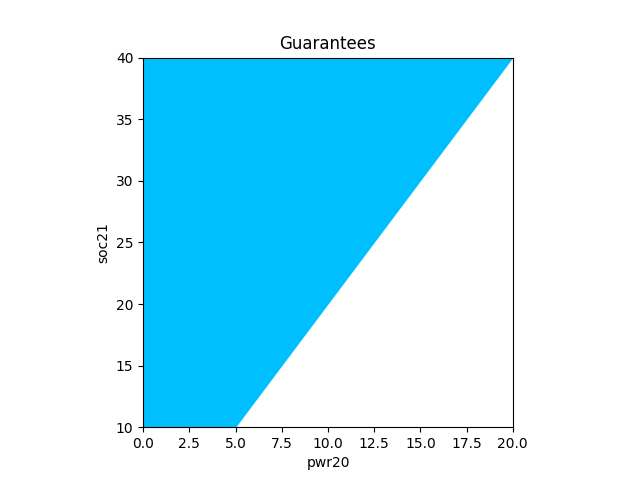

In [9]:
_,pwr1 = PWR_contract(s=20, generation=2.0, epsilon=epsilon)
print("Contract pwr1:")
print(pwr1)

_ = plot_guarantees(contract=pwr1,
                x_var=Var("pwr20"),
                y_var=Var("soc21"),
                var_values={
                  Var("d20"):0,
                  Var("d21"):0,
                  Var("e20"):0,
                  Var("e21"):0,
                  Var("r20"):0,
                  Var("r21"):0,
                  Var("soc20"):0,
                  Var("temp20"):0,
                  Var("temp21"):0,
                },
                x_lims=(0,20),
                y_lims=(10,40))

#### SBO Task (Small body observations)

In [10]:
# SBO:
# Parameters:
# - s: start index of the timeline variables
# - generation: rate of small body observations during the task instance
# - consumption: rate of battery discharge during the task instance
# - improvement: rate of trajectory error improvement during the task instance
# - epsilon: approximately zero
def SBO_contract(s: int, generation: float, consumption: float, improvement: float, epsilon: float) -> tuple[int, PolyhedralContract]:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      # f"t{s}",    # Scheduled start time
      f"soc{s}",  # initial battery SOC
      f"d{s}",    # initial data volume
      f"e{s}",    # initial trajectory error
      f"r{s}",    # initial relative distance
      f"temp{s}", # initial spacecraft thruster temperature
      f"sbo{s}",  # knob variable for SBO duration
    ],
    OutputVars = [
      # f"t{e}",    # Scheduled end time
      f"soc{e}",  # final battery SOC
      f"d{e}",    # final data volume
      f"e{e}",    # final trajectory error
      f"r{e}",    # final relative distance
      f"temp{e}", # final spacecraft thruster temperature
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-sbo{s} <= 0",

      # There is enough data storage available
      f"d{s} + {generation}*sbo{s} <= 100",

      # Battery has enough energy for consumption for the task instance
      f"-soc{s} + {consumption}*sbo{s} <= 0",
    ],
    guarantees = [
      # task ends after the dsn duration has elapsed
      # f"| t{e} - t{e} - sbo{s} | <= {epsilon}",
    
      # Battery discharges by at most duration*consumption
      f"soc{s} + {consumption}*sbo{s} - soc{e} <= 0",

      # Battery should not completely discharge
      f"-soc{e} <= 0",
      
      # data volume increases by at least duration*generation
      f"d{s} + {generation}*sbo{s} - d{e} <= 0",

      # Data volume cannot exceed the available storage capacity
      f"d{e} <= 100",
      
      # trajectory error improves by at least duration*improvement
      f"e{s} + {improvement}*sbo{s} - e{e} <= 0",

      # no change to the relative distance
      f"| r{e} - r{s} | <= {epsilon}",

      # cold thruster temperature
      f"temp{e} <= {epsilon}",
    ])
  return e, spec




Contract sbo1:
InVars: [soc30, d30, e30, r30, temp30, sbo30]
OutVars:[soc31, d31, e31, r31, temp31]
A: [
  -sbo30 <= 0.0
  d30 + 10.0 sbo30 <= 100.0
  4.0 sbo30 - soc30 <= 0.0
]
G: [
  4.0 sbo30 + soc30 - soc31 <= 0.0
  d30 - d31 + 10.0 sbo30 <= 0.0
  d31 <= 100.0
  e30 - e31 + 8.0 sbo30 <= 0.0
  |-r30 + r31| <= 0.0009999999999998899
  temp31 <= 0.0009999999999998899
]


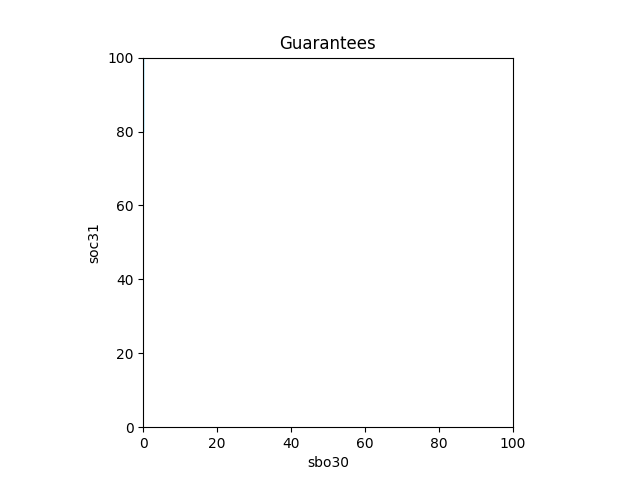

In [11]:
_,sbo1 = SBO_contract(s=30, generation=10.0, consumption=4.0, improvement=8.0, epsilon=epsilon)
print("Contract sbo1:")
print(sbo1)

_ = plot_guarantees(contract=sbo1,
                x_var=Var("sbo30"),
                y_var=Var("soc31"),
                var_values={
                  Var("d30"):0,
                  Var("d31"):70,
                  Var("e30"):0,
                  Var("e31"):0,
                  Var("r30"):0,
                  Var("r31"):0,
                  Var("soc30"):80,
                  Var("temp30"):0,
                  Var("temp31"):0,
                },
                x_lims=(0,100),
                y_lims=(0,100))

Contract sbo1.data:
InVars: [d30, sbo30]
OutVars:[d31]
A: [
  -sbo30 <= 0.0
  d30 + 10.0 sbo30 <= 100.0
]
G: [
  d30 - d31 + 10.0 sbo30 <= 0.0
  d31 <= 100.0
]


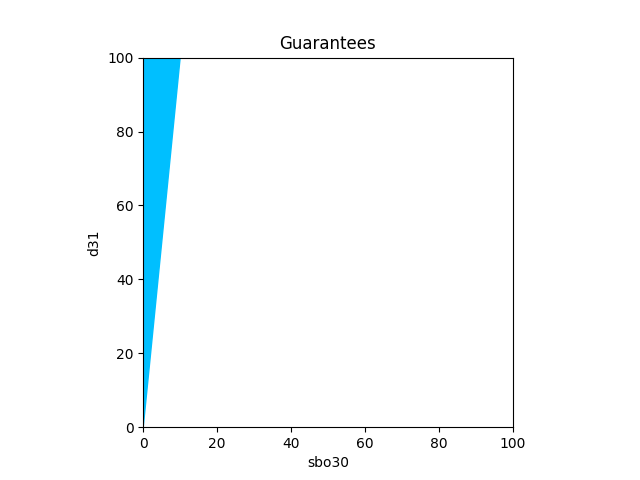

In [12]:

def SBOdata(s: int, generation: float, consumption: float, improvement: float, epsilon: float) -> tuple[int, PolyhedralContract]:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"d{s}",    # initial data volume
      f"sbo{s}",  # knob variable for SBO duration
    ],
    OutputVars = [
      f"d{e}",    # final data volume
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-sbo{s} <= 0",

      # There is enough data storage available
      f"d{s} + {generation}*sbo{s} <= 100",
    ],
    guarantees = [
      # data volume increases by at least duration*generation
      f"d{s} + {generation}*sbo{s} - d{e} <= 0",

      # Data volume cannot exceed the available storage capacity
      f"d{e} <= 100",
    ])
  return e, spec

_,sbo1_data = SBOdata(s=30, generation=10.0, consumption=4.0, improvement=8.0, epsilon=epsilon)
print("Contract sbo1.data:")
print(sbo1_data)

_ = plot_guarantees(contract=sbo1_data,
                x_var=Var("sbo30"),
                y_var=Var("d31"),
                var_values={
                  Var("d30"):0,
                },
                x_lims=(0,100),
                y_lims=(0,100))

Contract sbo1.battery
InVars: [soc30, sbo30]
OutVars:[soc31]
A: [
  -sbo30 <= 0.0
  4.0 sbo30 - soc30 <= 0.0
]
G: [
  -4.0 sbo30 + soc30 - soc31 <= 0.0
]


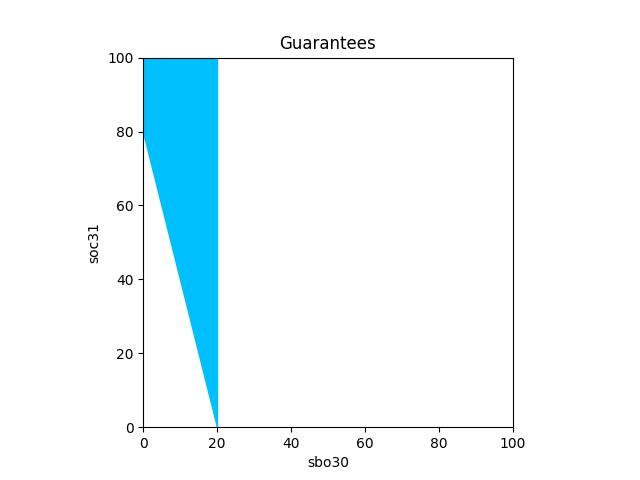

In [13]:

def SBObattery(s: int, generation: float, consumption: float, improvement: float, epsilon: float) -> tuple[int, PolyhedralContract]:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"soc{s}",  # initial battery SOC
      f"sbo{s}",  # knob variable for SBO duration
    ],
    OutputVars = [
      f"soc{e}",  # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-sbo{s} <= 0",

      # Battery has enough energy for consumption for the task instance
      f"-soc{s} + {consumption}*sbo{s} <= 0",
    ],
    guarantees = [
      # Battery discharges by at most duration*consumption
      f"-soc{e} - {consumption}*sbo{s} + soc{s} <= 0",

      # Battery should not completely discharge
      f"-soc{e} <= 0",
    ])
  return e, spec

_,sbo1_power = SBObattery(s=30, generation=10.0, consumption=4.0, improvement=8.0, epsilon=epsilon)
print("Contract sbo1.battery")
print(sbo1_power)

_ = plot_guarantees(contract=sbo1_power,
                x_var=Var("sbo30"),
                y_var=Var("soc31"),
                var_values={
                  Var("soc30"):80,
                },
                x_lims=(0,100),
                y_lims=(0,100))

Contract sbo1.nav:
InVars: [e30, sbo30]
OutVars:[e31]
A: [
  -sbo30 <= 0.0
]
G: [
  e30 - e31 + 8.0 sbo30 <= 0.0
]


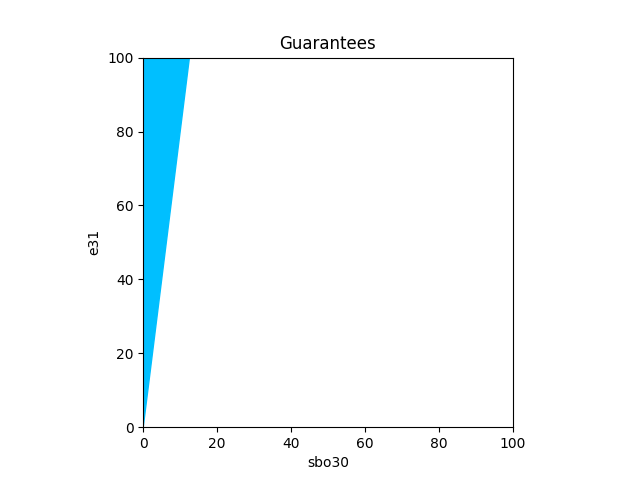

In [14]:
def SBOnav(s: int, generation: float, consumption: float, improvement: float, epsilon: float) -> tuple[int, PolyhedralContract]:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"e{s}",    # initial trajectory error
      f"sbo{s}",  # knob variable for SBO duration
    ],
    OutputVars = [
      f"e{e}",    # final trajectory error
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-sbo{s} <= 0",
    ],
    guarantees = [
      # trajectory error improves by at least duration*improvement
      f"e{s} + {improvement}*sbo{s} - e{e} <= 0",
    ])
  return e, spec

_,sbo1_nav = SBOnav(s=30, generation=10.0, consumption=4.0, improvement=8.0, epsilon=epsilon)
print("Contract sbo1.nav:")
print(sbo1_nav)

_ = plot_guarantees(contract=sbo1_nav,
                x_var=Var("sbo30"),
                y_var=Var("e31"),
                var_values={
                  Var("e30"):0,
                },
                x_lims=(0,100),
                y_lims=(0,100))

#### TCM Task (Perform a Trajectory Correction Maneuver)

In [15]:
# TCM:
# Parameters:
# - s: start index of the timeline variables
# - max_error: maximum relative trajectory error before the task instance
# - heating_cost: total battery discharge due to the heating required before the TCM
# - delta: relative trajectory improvement as a result of the delta-V thrust performed in this task instance
def TCM_contract(s: int, max_error: float, heating_cost: float, delta: float, epsilon: float) -> tuple[int, PolyhedralContract]:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      # f"t{s}",    # Scheduled start time
      f"soc{s}",  # initial battery SOC
      f"d{s}",    # initial data volume
      f"e{s}",    # initial trajectory error
      f"r{s}",    # initial relative distance
      f"temp{s}", # initial spacecraft thruster temperature
      f"tcm{s}",  # knob variable for TCM duration
    ],
    OutputVars = [
      # f"t{e}",    # Scheduled end time
      f"soc{e}",  # final battery SOC
      f"d{e}",    # final data volume
      f"e{e}",    # final trajectory error
      f"r{e}",    # final relative distance
      f"temp{e}", # final spacecraft thruster temperature
    ],
    assumptions = [
      # Battery SOC has enough to perform the heating
      f"-soc{s} + {heating_cost}*tcm{s} <= 0",

      # Max trajectory error
      f"e{s} <= {max_error}",
    ],
    guarantees = [
      # task ends after the duration has elapsed
      # f"| t{e} - t{s} - tcm{s} | <= {epsilon}",

      # Battery discharges by at most heating_cost
      f"soc{s} + {heating_cost}*tcm{s} - soc{e} <= 0",

      # no change to the data volume
      f"| d{e} - d{s} | <= {epsilon}",

      # no change to trajectory error
      f"| e{e} - e{s} | <= {epsilon}",

      # trajectory improves by at least delta
      f"r{s} - r{e} <= -{delta}",

      # cold thruster temperature
      f"temp{e} <= {epsilon}",
    ])
  return e, spec

### Schedule examples

In [16]:
s1,init=initial_contract(epsilon=epsilon)
print("Contract init:")
print(init)


TypeError: cannot unpack non-iterable PolyhedralContract object

In [ ]:
s5,tcm1 = TCM_contract(s=40, max_error=4.0, heating_cost=40.0, delta=5.0, epsilon=epsilon)
print("Contract tcm1:")
print(tcm1)

Contract tcm1:
InVars: [soc40, d40, e40, r40, temp40, tcm40]
OutVars:[soc41, d41, e41, r41, temp41]
A: [
  -soc40 + 40.0 tcm40 <= 0.0
  e40 <= 4.0
]
G: [
  soc40 - soc41 + 40.0 tcm40 <= 0.0
  |-d40 + d41| <= 0.0009999999999998899
  |-e40 + e41| <= 0.0009999999999998899
  r40 - r41 <= -5.0
  temp41 <= 0.0009999999999998899
]


In [ ]:
# This composition is well-formed; however, the variables are disjoint!
c0a = init.compose(sbo1)
print("Contract c0a = init.compose(sbo1):")
print(c0a)

Contract c0a = init.compose(sbo1):
InVars: [soc30, d30, e30, r30, temp30, sbo30]
OutVars:[soc1, d1, e1, r1, temp1, soc31, d31, e31, r31, temp31]
A: [
  -sbo30 <= 0.0
  -d30 + 10.0 sbo30 <= 0.0
  4.0 sbo30 - soc30 <= 0.0
]
G: [
  -soc1 <= -100.0
  -d1 <= 0.0
  -e1 <= 0.0
  -r1 <= -100.0
  temp1 <= 0.0009999999999998899
  4.0 sbo30 + soc30 - soc31 <= 0.0
  d30 - d31 + 10.0 sbo30 <= 0.0
  e30 - e31 + 8.0 sbo30 <= 0.0
  |-r30 + r31| <= 0.0009999999999998899
  temp31 <= 0.0009999999999998899
]


In [ ]:
# Correct composition with a contract connector
c0b = connect(init, sbo1, varPrefixes)
print("Contract c0b = connect(init, sbo1, varPrefixes):")
print(c0b)

ValueError: Cannot match variable: sbo30 to any of [<Var soc1>, <Var d1>, <Var e1>, <Var r1>, <Var temp1>] using prefixes: ['t', 'soc', 'd', 'e', 'r', 'temp']

#### Creating the schedule of task instances by composing the task instance contracts (the compositions below are all wrong because the variables are disjoint!)

To compose contracts, we need to generate composable input/ouput variables.

In [ ]:
c1 = dsn1.compose(pwr1)
print("Contract dsn1.compose(pwr1):")
print(c1)

In [ ]:
c2 = c1.compose(sbo1)
print("Contract c1.compose(sbo1):")
print(c2)

In [ ]:
c3 = c2.compose(tcm1)
print("Contract c2.compose(tcm1):")
print(c3)

## References

<a id="ref1"></a> __[Chien et al. 2012](https://ai.jpl.nasa.gov/public/documents/papers/chien_spaceops2012_generalized.pdf)__

Chien, S.; Johnston, M.; Policella, N.; Frank, J.; Lenzen, C.; Giuliano, M.; and Kavelaars, A. 
**A generalized timeline representation, services, and interface for automating space mission operations.** 
In International Conference On Space Operations (SpaceOps 2012), Stockholm, Sweden, June 2012. 

<a id="ref2"></a> __[Rabideau et al. 2017](https://arc.aiaa.org/doi/pdf/10.2514/1.I010544)__

Rabideau, G.; Chien, S.; Galer, M.; Nespoli, F.; and Costa, M. 
**Managing Spacecraft Memory Buffers with Concurrent Data Collection and Downlink.** 
Journal of Aerospace Information Systems (JAIS). December 2017.

<a id="ref3"></a> __[Chen et al. 2003](https://www.researchgate.net/profile/Benjamin-Wah/publication/2861650_Automated_Planning_and_Scheduling_using_Calculus_of_Variations/links/54db35b20cf261ce15cf7)__

Chen, Y. and Wah, B. 
**Automated Planning and Scheduling using Calculus of Variations.**
13th International Conference on Automated Planning&Scheduling (ICAPS 2003), Trento, Italy, June 2003.

<a id="ref4"></a> __[Ghallab et al. 1998](https://planning.wiki/_citedpapers/pddl1998.pdf)__

Ghallab, M., Knoblock, C., Wilkins, D., Barrett, A., Christianson, D., Friedman, M., Kwok, C., Golden, K., Penberthy, S., Smith, D., Sun, Y., & Weld, D. (1998). 
**PDDL - The Planning Domain Definition Language.**

<a id="ref5"></a> __[Nesnas et al. 2021](https://www.frontiersin.org/articles/10.3389/frobt.2021.650885/full)__

Nesnas, I. A. D., Hockman, B. J., Bandopadhyay, S., Morrell, B. J., Lubey, D. P., Villa, J., Bayard, D. S., Osmundson, A., Jarvis, B., Bersani, M., Bhaskaran, S.
**Autonomous Exploration of Small Bodies Toward Greater Autonomy for Deep Space Missions**
In Frontiers in Robotics and AI, volume 8, November 2021.